In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import time
import statsmodels.api as sm
from sklearn import linear_model
from tqdm import tnrange, tqdm_notebook
from sklearn.metrics import mean_squared_error
from statsmodels.regression.quantile_regression import QuantReg

In [38]:
train = pd.read_csv('data/train/train.csv')
sub = pd.read_csv('data/sample_submission.csv')

In [6]:
len(train) # 365 x 3 x 48

52560

In [48]:
train.describe()

Day          Hour        Minute           DHI           DNI  \
count  52560.000000  52560.000000  52560.000000  52560.000000  52560.000000   
mean     547.000000     11.500000     15.000000     64.344121    234.792371   
std      316.102148      6.922252     15.000143    103.897125    349.684583   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%      273.000000      5.750000      0.000000      0.000000      0.000000   
50%      547.000000     11.500000     15.000000      0.000000      0.000000   
75%      821.000000     17.250000     30.000000     87.000000    469.000000   
max     1094.000000     23.000000     30.000000    528.000000   1059.000000   

                 WS            RH             T        TARGET  
count  52560.000000  52560.000000  52560.000000  52560.000000  
mean       2.456033     56.793102      9.279928     17.790630  
std        1.426874     22.052875     10.179741     25.759955  
min        0.000000      7.590000    -19.000000      0.000000  
25%        1.400000     39.697500      1.000000      0.000000  
50%        2.200000     57.600000      9.000000      0.000000  
75%        3.200000     72.770000     17.000000     32.089890  
max       12.000000    100.000000     35.000000     99.913939

# 전처리


가장 가까운 정보(2일 전 데이터)로 미래를 예측

In [10]:
for i in range(0,81):
    s1 = "test_%d = pd.read_csv('data/test/%d.csv')"%(i,i)
    exec(s1)

In [11]:
for i in range(0, 1093):
    s1 = "train_%d = pd.concat([train.loc[train['Day'] == %d].reset_index(drop = True), train.loc[train['Day'] == %d + 2].reset_index(drop = True).rename(columns = {'TARGET' : 'TARGET_2'})['TARGET_2']], axis = 1)"%(i, i, i)
    exec(s1)

In [12]:
train_x = pd.concat([train_0, train_1], axis = 0).reset_index(drop=True)
train_x

Day  Hour  Minute  DHI  DNI   WS     RH   T  TARGET  TARGET_2
0     0     0       0    0    0  1.5  69.08 -12     0.0       0.0
1     0     0      30    0    0  1.5  69.06 -12     0.0       0.0
2     0     1       0    0    0  1.6  71.78 -12     0.0       0.0
3     0     1      30    0    0  1.6  71.75 -12     0.0       0.0
4     0     2       0    0    0  1.6  75.20 -12     0.0       0.0
..  ...   ...     ...  ...  ...  ...    ...  ..     ...       ...
91    1    21      30    0    0  2.2  74.50  -8     0.0       0.0
92    1    22       0    0    0  2.2  72.83  -8     0.0       0.0
93    1    22      30    0    0  2.2  72.82  -8     0.0       0.0
94    1    23       0    0    0  2.2  72.51  -8     0.0       0.0
95    1    23      30    0    0  2.2  72.49  -8     0.0       0.0

[96 rows x 10 columns]

In [26]:
for i in range(len(train_x['T']) ):
    if i == len(train_x['T'])-1:
        break
    if train_x['T'][i] == train_x['T'][i+1] :
        print(train_x['T'][i])



-12
-12
-12
-12
-11
-11
-11
-11
-11
-11
-12
-12
-3
-3
-3
-3
-3
-4
-4
-4
-5
-6
-7
-8
-8
-8
-8
-8
-9
-9
-9
-10
-10
-10
-11
-11
-11
-12
-12
-12
-12
-12
-12
-12
-12
0
0
1
1
0
-6
-7
-8
-8
-8
-8
-8
-8
-8


In [30]:
for i in range(2, 1093):
    s1 = "train_x = pd.concat([train_x, train_%d], axis = 0).reset_index(drop = True)"%(i)
    exec(s1)

In [31]:
#변수생성
hour_mean = train_x.groupby(['Hour'])['TARGET'].mean()
minute_mean = train_x.groupby(['Minute'])['TARGET'].mean()
train_x['Hour_mean'] = train_x['Hour'].map(hour_mean)
train_x['Minute_mean'] = train_x['Minute'].map(minute_mean)

In [32]:
train_x = train_x.drop(['Day', 'Hour', 'Minute'], axis = 1)
train_x

DHI  DNI   WS     RH   T  TARGET  TARGET_2  Hour_mean  Minute_mean
0        0    0  1.5  69.08 -12     0.0       0.0        0.0    17.810955
1        0    0  1.5  69.06 -12     0.0       0.0        0.0    17.799137
2        0    0  1.6  71.78 -12     0.0       0.0        0.0    17.810955
3        0    0  1.6  71.75 -12     0.0       0.0        0.0    17.799137
4        0    0  1.6  75.20 -12     0.0       0.0        0.0    17.810955
...    ...  ...  ...    ...  ..     ...       ...        ...          ...
52459    0    0  3.5  55.97  -1     0.0       0.0        0.0    17.799137
52460    0    0  3.9  54.23  -2     0.0       0.0        0.0    17.810955
52461    0    0  4.1  54.21  -2     0.0       0.0        0.0    17.799137
52462    0    0  4.3  56.46  -2     0.0       0.0        0.0    17.810955
52463    0    0  4.1  56.44  -2     0.0       0.0        0.0    17.799137

[52464 rows x 9 columns]

y : TARGET_2(2일 후 발전량)

In [33]:
x_train = train_x.drop(['TARGET_2'], axis = 1)
y_train = train_x['TARGET_2']

In [34]:
for i in range(0, 81):
    s1 = "test_%d = test_%d[240:].reset_index(drop = True)"%(i,i)
    s2 = "hour_mean = test_%d.groupby(['Hour'])['TARGET'].mean()"%(i)
    s3 = "minute_mean = test_%d.groupby(['Minute'])['TARGET'].mean()"%(i)
    s4 = "test_%d['Hour_mean'] = test_%d['Hour'].map(hour_mean)"%(i,i)
    s5 = "test_%d['Minute_mean'] = test_%d['Minute'].map(minute_mean)"%(i,i)
    s6 = "test_%d = test_%d.drop(['Day', 'Hour', 'Minute'], axis = 1)"%(i,i)
    exec(s1)
    exec(s2)
    exec(s3)
    exec(s4)
    exec(s5)
    exec(s6)

In [35]:
test_x = pd.concat([test_0, test_1], axis = 0).reset_index(drop=True)
test_x

DHI  DNI   WS     RH    T  TARGET  Hour_mean  Minute_mean
0      0    0  2.1  52.83 -4.4     0.0        0.0     6.061008
1      0    0  2.0  54.44 -4.8     0.0        0.0     5.926100
2      0    0  1.9  52.78 -5.1     0.0        0.0     6.061008
3      0    0  1.8  53.59 -5.3     0.0        0.0     5.926100
4      0    0  1.7  52.63 -5.5     0.0        0.0     6.061008
..   ...  ...  ...    ...  ...     ...        ...          ...
187    0    0  1.7  43.65 -5.2     0.0        0.0    11.308777
188    0    0  1.5  40.62 -4.9     0.0        0.0    11.297040
189    0    0  1.5  40.62 -4.9     0.0        0.0    11.308777
190    0    0  1.5  39.21 -4.9     0.0        0.0    11.297040
191    0    0  1.5  39.50 -5.0     0.0        0.0    11.308777

[192 rows x 8 columns]

In [36]:
for i in range(2, 81):
    s1 = "test_x = pd.concat([test_x, test_%d], axis = 0).reset_index(drop = True)"%(i)
    exec(s1)

In [37]:
x_test = test_x.copy()

# 변수선택(best subest)

In [38]:
def linear_reg(X,y):
    model = linear_model.LinearRegression(fit_intercept = True)
    model.fit(X,y)
    RSS = mean_squared_error(y,model.predict(X)) * len(y)
    R_squared = model.score(X,y)
    return RSS, R_squared

#X변수 개수
m = len(y_train)
k = 8
RSS_list, R_squared_list, feature_list = [],[], []
numb_features = []

#1 ~ 8까지 모든 조합에 대한 성능 테스트(RSS, R_Squared)
for k in tnrange(1,len(x_train.columns) + 1):
    for combo in itertools.combinations(x_train.columns,k):
        tmp_result = linear_reg(x_train[list(combo)],y_train)  
        RSS_list.append(tmp_result[0])              
        R_squared_list.append(tmp_result[1])
        feature_list.append(combo)
        numb_features.append(len(combo))   

#결과
df = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list, 'R_squared':R_squared_list,'features':feature_list})

<ipython-input-38-d0afe2482ad3>:15: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(x_train.columns) + 1):


In [39]:
df['min_RSS'] = df.groupby('numb_features')['RSS'].transform(min)
df['max_R_squared'] = df.groupby('numb_features')['R_squared'].transform(max)
df.head()

numb_features           RSS  R_squared features       min_RSS  \
0              1  1.762009e+07   0.494386   (DHI,)  1.058685e+07   
1              1  2.235501e+07   0.358516   (DNI,)  1.058685e+07   
2              1  3.281036e+07   0.058496    (WS,)  1.058685e+07   
3              1  2.265496e+07   0.349909    (RH,)  1.058685e+07   
4              1  2.578791e+07   0.260008     (T,)  1.058685e+07   

   max_R_squared  
0       0.696207  
1       0.696207  
2       0.696207  
3       0.696207  
4       0.696207

In [40]:
df_min = df[df.groupby('numb_features')['RSS'].transform(min) == df['RSS']]
display(df_min.head(5))

numb_features           RSS  R_squared                          features  \
6                1  1.058685e+07   0.696207                      (Hour_mean,)   
33               2  8.892195e+06   0.744836               (TARGET, Hour_mean)   
69               3  8.319371e+06   0.761273          (DNI, TARGET, Hour_mean)   
143              4  8.105550e+06   0.767409       (DNI, T, TARGET, Hour_mean)   
178              5  8.092551e+06   0.767782  (DHI, DNI, T, TARGET, Hour_mean)   

          min_RSS  max_R_squared  
6    1.058685e+07       0.696207  
33   8.892195e+06       0.744836  
69   8.319371e+06       0.761273  
143  8.105550e+06       0.767409  
178  8.092551e+06       0.767782

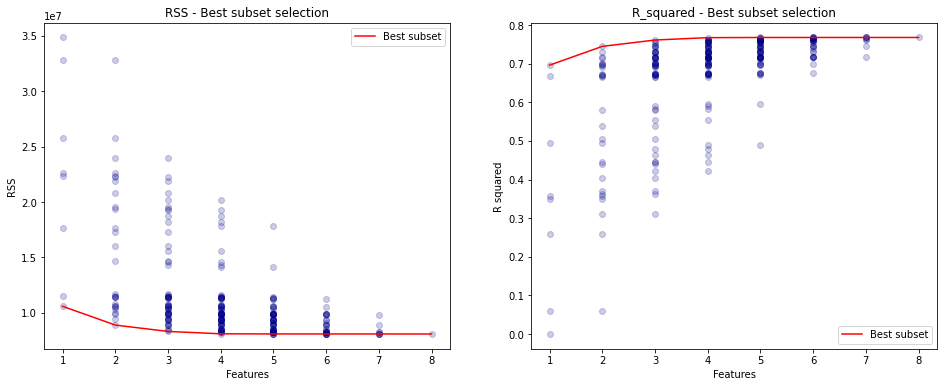

In [41]:
fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(1, 2, 1)

ax.scatter(df.numb_features,df.RSS, alpha = .2, color = 'darkblue' )
ax.plot(df.numb_features,df.min_RSS,color = 'r', label = 'Best subset')
ax.set_xlabel('Features')
ax.set_ylabel('RSS')
ax.set_title('RSS - Best subset selection')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.scatter(df.numb_features,df.R_squared, alpha = .2, color = 'darkblue' )
ax.plot(df.numb_features,df.max_R_squared,color = 'r', label = 'Best subset')
ax.set_xlabel('Features')
ax.set_ylabel('R squared')
ax.set_title('R_squared - Best subset selection')
ax.legend()

plt.show()

# 예측

In [42]:
sub['q_0.1'] = QuantReg(y_train, x_train['Hour_mean']).fit(q=0.1).predict(x_test['Hour_mean'])
sub['q_0.2'] = QuantReg(y_train, x_train['Hour_mean']).fit(q=0.2).predict(x_test['Hour_mean'])
sub['q_0.3'] = QuantReg(y_train, x_train['Hour_mean']).fit(q=0.3).predict(x_test['Hour_mean'])
sub['q_0.4'] = QuantReg(y_train, x_train['Hour_mean']).fit(q=0.4).predict(x_test['Hour_mean'])
sub['q_0.5'] = QuantReg(y_train, x_train['Hour_mean']).fit(q=0.5).predict(x_test['Hour_mean'])
sub['q_0.6'] = QuantReg(y_train, x_train['Hour_mean']).fit(q=0.6).predict(x_test['Hour_mean'])
sub['q_0.7'] = QuantReg(y_train, x_train['Hour_mean']).fit(q=0.7).predict(x_test['Hour_mean'])
sub['q_0.8'] = QuantReg(y_train, x_train['Hour_mean']).fit(q=0.8).predict(x_test['Hour_mean'])
sub['q_0.9'] = QuantReg(y_train, x_train['Hour_mean']).fit(q=0.9).predict(x_test['Hour_mean'])

In [44]:
sub.to_csv('1214_third.csv', index = False)